# MISSING DATA EXPLO FOR WEATHER DATASET (6-minute)

### Load Weather Data

In [3]:
import pandas as pd

In [4]:
input_weather_dir = "/Volumes/SSD/Epfl/Master/MA3/FBD/data/intermediate/parquet/weather/6minute/"
df_weather = pd.read_parquet(input_weather_dir + "01027003_BALAN-AERO.parquet")
df_weather.head()

,td,ta,rh,wd,ws,dxi10,ws_max,cumul_precip,ts_10,ts_20,...,soil_st,snow_height,insolh_duration,glo,pres,pres_sl,station_name,lon,lat,alt
time,,,,,,,,,,,,,,,,,,,,,
2023-07-07 12:06:00,288.250000,302.950012,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,b'BALAN-AERO',5.1067,45.833,196.0
2023-07-07 12:12:00,289.350006,303.350006,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,b'BALAN-AERO',5.1067,45.833,196.0
2023-07-07 12:18:00,288.450012,303.549988,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,b'BALAN-AERO',5.1067,45.833,196.0
2023-07-07 12:24:00,288.950012,303.750000,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,b'BALAN-AERO',5.1067,45.833,196.0
2023-07-07 12:30:00,288.750000,303.850006,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,b'BALAN-AERO',5.1067,45.833,196.0


### Compute Missing Values Percentage for Wind Speed

In [5]:
def check_missing_data(df):
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
    return missing_df

check_missing_data(df_weather)

,Missing Values,Percentage
td,488,0.417308
ta,487,0.416453
rh,485,0.414743
wd,116940,100.000000
ws,116940,100.000000
dxi10,116940,100.000000
ws_max,116940,100.000000
cumul_precip,116940,100.000000
ts_10,116940,100.000000
ts_20,116940,100.000000


In [6]:
def check_missing_ws_values(df):
    df = df[['ws']]
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
    return missing_df

check_missing_ws_values(df_weather)

,Missing Values,Percentage
ws,116940,100.0


In [ ]:
from tqdm import tqdm
from pathlib import Path

missing_ws_stats_list = []

weather_files = [f for f in Path(input_weather_dir).glob("*.parquet") if not f.name.startswith("._")]
        
iterator = tqdm(weather_files, desc="Computing missing ws statistics", unit="file")
for energy_file in iterator:
    station_id = energy_file.stem
    df_weather = pd.read_parquet(energy_file)

    missing_ws_df = check_missing_ws_values(df_weather)
    missing_ws_values = missing_ws_df.loc['ws', 'Missing Values']
    missing_ws_percentage = missing_ws_df.loc['ws', 'Percentage']

    missing_ws_stats_list.append({
        'station_id': station_id,
        'missing_ws_values': missing_ws_values,
        'missing_ws_percentage': missing_ws_percentage
    })

# Create DataFrame once after the loop
missing_ws_stats_df = pd.DataFrame(missing_ws_stats_list)
missing_ws_stats_df.head()

Computing returns for all stations: 100%|██████████| 1724/1724 [01:37<00:00, 17.77it/s]


,station_id,missing_ws_values,missing_ws_percentage
0,94068001_ST-MAUR,129912,100.000000
1,59183001_DUNKERQUE,343,0.264055
2,64310001_LANNE-EN-BARETOUS-SAPC,171132,100.000000
3,01072001_CEYZERIAT-SAPC,129911,100.000000
4,88402002_ROVILLE,17,0.013101


### Plot histogram of missing wind speed values percentage

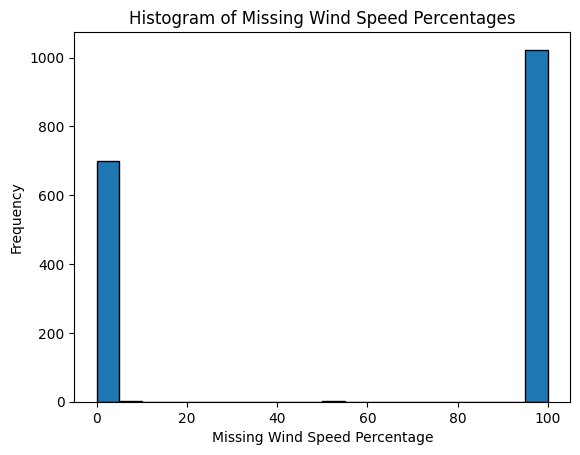

In [13]:
import matplotlib.pyplot as plt

plt.hist(missing_ws_stats_df['missing_ws_percentage'], bins=20, edgecolor='black')
plt.xlabel('Missing Wind Speed Percentage')
plt.ylabel('Frequency')
plt.title('Histogram of Missing Wind Speed Percentages')
plt.show()

### Plot Missing Values on France Map

In [9]:
meta_list = []
for f in weather_files:
    station_id = f.stem
    try:
        meta = pd.read_parquet(f, columns=['lon', 'lat']).iloc[0]
        meta_list.append({'station_id': station_id, 'lon': float(meta['lon']), 'lat': float(meta['lat'])})
    except Exception:
        meta_list.append({'station_id': station_id, 'lon': None, 'lat': None})
        print(f"Could not read metadata for station {station_id}")

meta_df = pd.DataFrame(meta_list)

missing_ws_with_loc = missing_ws_stats_df.merge(meta_df, on='station_id', how='left')
missing_ws_with_loc = missing_ws_with_loc.sort_values('missing_ws_percentage', ascending=False)

# show top stations with highest missing percentages
missing_ws_with_loc.head(20)

,station_id,missing_ws_values,missing_ws_percentage,lon,lat
0,94068001_ST-MAUR,129912,100.0,2.4923,48.808701
975,74063002_CHATEL,174946,100.0,6.8188,46.255798
989,12039001_BRUSQUE-SAPC,129910,100.0,2.9387,43.749500
987,50174001_EQUILLY,174839,100.0,-1.3887,48.834499
984,36141001_NEUVY-ST-SEP,174926,100.0,1.7985,46.598301
983,63129001_CROS,174924,100.0,2.5950,45.472000
982,36169001_PRUNIERS,174867,100.0,2.0450,46.788502
981,42299001_SAVIGNEUX,174944,100.0,4.0787,45.624802
976,17111001_CLION,174938,100.0,-0.5103,45.476799
972,65447001_TOURNAY,174935,100.0,0.2437,43.179001


#### Using Geopandas

In [10]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(missing_ws_with_loc['lon'], missing_ws_with_loc['lat'])]
gdf = gpd.GeoDataFrame(missing_ws_with_loc, geometry=geometry, crs='EPSG:4326')

gdf.explore(
    column='missing_ws_percentage',  # color by this column
    cmap='RdYlGn_r',  # red-yellow-green reversed (red=high)
    tooltip=['station_id', 'missing_ws_percentage'],  # show on hover
    popup=True,  # show all values on click
    tiles='CartoDB positron',  # background map style
    marker_kwds=dict(radius=5, fill=True),
    legend=True,
    legend_kwds=dict(caption='Missing WS Values (%) - 6-minute Data'),
    location=[46.5, 2.5],
    zoom_start=6
)


#### Using Plotly

In [11]:
import plotly.express as px

fig = px.scatter_map(
    missing_ws_with_loc,
    lat='lat',
    lon='lon',
    color='missing_ws_percentage',
    hover_name='station_id',
    hover_data={
        'station_id': True,
        'missing_ws_percentage': ':.2f',
        'lat': False,
        'lon': False
    },
    color_continuous_scale='RdYlGn_r',  # red-yellow-green reversed (red=high missing)
    zoom=4.63,
    center={'lat': 46.5, 'lon': 2.5},  # center of France
    title='Wind Speed Missing Values by Station (6-minute Data)'
)

fig.update_layout(
    mapbox_style='open-street-map',
    height=700,
    width=900,
    coloraxis_colorbar=dict(
        title='Missing %',
        ticksuffix='%'
    )
)

fig.show()


#### Using Folium (html file to be visualized on browser)

In [12]:
import folium
from branca.colormap import LinearColormap

m = folium.Map(location=[46.5, 2.5], zoom_start=6)

colormap = LinearColormap(
    colors=['green', 'yellow', 'red'],
    vmin=missing_ws_with_loc['missing_ws_percentage'].min(),
    vmax=missing_ws_with_loc['missing_ws_percentage'].max(),
    caption='Missing Values (%)'
)

for idx, row in missing_ws_with_loc.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=f"Station: {row['station_id']}<br>Missing: {row['missing_ws_percentage']:.2f}%",
        tooltip=f"{row['station_id']}: {row['missing_ws_percentage']:.2f}%",
        color=colormap(row['missing_ws_percentage']),
        fill=True,
        fillColor=colormap(row['missing_ws_percentage']),
        fillOpacity=0.7
    ).add_to(m)

colormap.add_to(m)

m.save('../reports/figures/france_stations_map_missing_ws_percentage_6minute.html')
